# Выявление закономерностей, определющих успех компьютерных игр

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
sns.set(style="darkgrid")
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.simplefilter('ignore')

## общая информация

In [192]:
games_raw = pd.read_csv('/datasets/games.csv')

In [193]:
games_raw.columns = [column.lower() for column in games_raw.columns]

In [194]:
games_raw.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [195]:
games_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [196]:
games_raw.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
count,16713,16715,"16,446.00",16713,"16,715.00","16,715.00","16,715.00","16,715.00","8,137.00",10014,9949
unique,11559,31,nan,12,nan,nan,nan,nan,nan,96,8
top,Need for Speed: Most Wanted,PS2,nan,Action,nan,nan,nan,nan,nan,tbd,E
freq,12,2161,nan,3369,nan,nan,nan,nan,nan,2424,3990
mean,NaN,NaN,"2,006.48",NaN,0.26,0.15,0.08,0.05,68.97,NaN,NaN
std,NaN,NaN,5.88,NaN,0.81,0.50,0.31,0.19,13.94,NaN,NaN
min,NaN,NaN,"1,980.00",NaN,0.00,0.00,0.00,0.00,13.00,NaN,NaN
25%,NaN,NaN,"2,003.00",NaN,0.00,0.00,0.00,0.00,60.00,NaN,NaN
50%,NaN,NaN,"2,007.00",NaN,0.08,0.02,0.00,0.01,71.00,NaN,NaN
75%,NaN,NaN,"2,010.00",NaN,0.24,0.11,0.04,0.03,79.00,NaN,NaN


## Подготовка данных

### Приведение типов данных

In [197]:
games_raw['user_score'].value_counts().head(5)

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
Name: user_score, dtype: int64

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Приводим типы данных: 
    
 - year_of_release переведем в формат даты
    
    
 - при работе с числами видим, что Pandas некоторым столбцам присвоил избыточные типы данных, которые занимают лишнее место в памяти. Такие столбцы тоже приобразуем в соответствующий тип
    
    
 - столбец user_score (оценка пользователей) должен иметь числовой тип данных. tbd - это, скорее всего, означает To Be   Determined. То есть "будет отпределено". Это означает, что данных нет

<div>

In [198]:
games_raw['year_of_release'] = pd.to_datetime(games_raw['year_of_release'], format='%Y')
games_raw['year_of_release'] = games_raw['year_of_release'].values.astype('datetime64[Y]')

games_raw['na_sales']        = games_raw['na_sales'].astype('float16')
games_raw['eu_sales']        = games_raw['eu_sales'].astype('float16')
games_raw['jp_sales']        = games_raw['jp_sales'].astype('float16')
games_raw['other_sales']     = games_raw['other_sales'].astype('float16')

games_raw['critic_score']     = games_raw['critic_score'].astype('float16')

games_raw['user_score']      = games_raw['user_score'].replace(['tbd'],np.NaN)
games_raw['user_score']      = games_raw['user_score'].astype('float16')

In [199]:
games_raw.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006-01-01,Sports,41.38,28.95,3.77,8.45,76.00,8.00,E
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,nan,nan,NaN
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,NaN


In [200]:
games_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16715 non-null float16
eu_sales           16715 non-null float16
jp_sales           16715 non-null float16
other_sales        16715 non-null float16
critic_score       8137 non-null float16
user_score         7590 non-null float16
rating             9949 non-null object
dtypes: datetime64[ns](1), float16(6), object(4)
memory usage: 848.9+ KB


### Чистка данных

**Статистика по пропускам**

In [201]:
pd.DataFrame(
    [round((games_raw.isna().mean()*100),2), games_raw.isna().sum()]).T \
    .rename(columns={0: 'percent_na', 1: 'count_na'}) \
    .sort_values(by='count_na', ascending=False) \
    .style.background_gradient('coolwarm')

,percent_na,count_na
user_score,54.59,9125
critic_score,51.32,8578
rating,40.48,6766
year_of_release,1.61,269
name,0.01,2
genre,0.01,2
platform,0,0
na_sales,0,0
eu_sales,0,0
jp_sales,0,0


In [202]:
games_clean = games_raw.copy()

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Посмотрим, на две записи с отсутствующим значением в столбце name

<div>

In [203]:
games_clean.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,nan,nan,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,nan,nan,NaN


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Эти записи нам не подходят, т.к. помимо имени и жанра мы не видим рейтнги - показатель успешности игры

<div>

In [204]:
games_clean = games_clean.query('name.notna()')

### Восстановление данных

<div style="border:solid gray 2.0px; padding: 10px"> 
    
1. Попробуем каким-то образом частично восстановить год выпуска (year_of_release).

    Идея такая: посмотрим для каждой игры, какие значение встречаются в колонке year_of_release.
    Для тех игр, у которых будет встречаться только одно значение, и никакие больше можно принять, что год выпуска нам известен.
    Пропущеные значения для ирг, у которых мы знаем год релиза, восстановим
    
    
2. По такому же принципу пройдемся по столбцу rating

    
3. Столбцы оценка критиков (critic_score) и user_score восстанавливать не будем, т.к. очень большой процент пропусков. И это может исказить данные
<div>

#### год выпуска (year_of_release)

In [205]:
games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16713 non-null float16
eu_sales           16713 non-null float16
jp_sales           16713 non-null float16
other_sales        16713 non-null float16
critic_score       8137 non-null float16
user_score         7590 non-null float16
rating             9949 non-null object
dtypes: datetime64[ns](1), float16(6), object(4)
memory usage: 979.3+ KB


In [206]:
#группируем по year_of_release, записываем в уникальный массив (множество)
games_release = games_clean.query('year_of_release.notnull()').groupby(['name'])['year_of_release'].agg(set).reset_index()
games_release['len'] = games_release['year_of_release'].str.len()

#оставляем только игры, у которых только один вариант с годом релиза
games_release = games_release.query("len==1")

##преобразуем значения столбца из списка из одного элемента в сам элемент
games_release['year_of_release'] = games_release['year_of_release'].apply(lambda x: list(x)[0])

games_release = games_release[['name', 'year_of_release']]
games_release = games_release.rename(columns={'year_of_release': 'year_of_release_rec'})
games_release.head(5)

,name,year_of_release_rec
0,Beyblade Burst,2016-01-01
1,Fire Emblem Fates,2015-01-01
2,Frozen: Olaf's Quest,2013-01-01
3,Haikyu!! Cross Team Match!,2016-01-01
4,Tales of Xillia 2,2012-01-01


In [207]:
games_clean = pd.merge(games_clean, games_release, on=['name'], how='left')
games_clean['year_of_release'] = games_clean['year_of_release'].fillna(games_clean['year_of_release_rec'])

In [208]:
games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16712
Data columns (total 12 columns):
name                   16713 non-null object
platform               16713 non-null object
year_of_release        16555 non-null datetime64[ns]
genre                  16713 non-null object
na_sales               16713 non-null float16
eu_sales               16713 non-null float16
jp_sales               16713 non-null float16
other_sales            16713 non-null float16
critic_score           8137 non-null float16
user_score             7590 non-null float16
rating                 9949 non-null object
year_of_release_rec    14677 non-null datetime64[ns]
dtypes: datetime64[ns](2), float16(6), object(4)
memory usage: 1.1+ MB


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Не намного, но стало лучше: в столбце year_of_release 16455 значений заполнено, до этого было 16446 ))

<div>

#### рейтинг от организации ESRB (rating)

In [209]:
#группируем, записываем в уникальный массив (множество)
games_rating = games_clean.query('rating.notnull()').groupby(['name'])['rating'].agg(set).reset_index()
games_rating['len'] = games_rating['rating'].str.len()

#оставляем только игры, у которых только один вариант
games_rating = games_rating.query("len==1")

##преобразуем значения столбца из списка из одного элемента в сам элемент
games_rating['rating'] = games_rating['rating'].apply(lambda x: list(x)[0])

games_rating = games_rating[['name', 'rating']]
games_rating = games_rating.rename(columns={'rating': 'rating_rec'})
games_rating.head(5)

,name,rating_rec
0,Tales of Xillia 2,T
1,.hack//Infection Part 1,T
2,.hack//Mutation Part 2,T
3,.hack//Outbreak Part 3,T
4,007 Racing,T


In [210]:
games_clean = pd.merge(games_clean, games_rating, on=['name'], how='left')
games_clean['rating'] = games_clean['rating'].fillna(games_clean['rating_rec'])

In [211]:
games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16712
Data columns (total 13 columns):
name                   16713 non-null object
platform               16713 non-null object
year_of_release        16555 non-null datetime64[ns]
genre                  16713 non-null object
na_sales               16713 non-null float16
eu_sales               16713 non-null float16
jp_sales               16713 non-null float16
other_sales            16713 non-null float16
critic_score           8137 non-null float16
user_score             7590 non-null float16
rating                 10365 non-null object
year_of_release_rec    14677 non-null datetime64[ns]
rating_rec             9659 non-null object
dtypes: datetime64[ns](2), float16(6), object(5)
memory usage: 1.2+ MB


<div style="border:solid gray 2.0px; padding: 10px"> 
    
В столбце rating тоже часть данных восстановили: year_of_release 10365 значений заполнено, до этого было 9949

<div>

In [212]:
games_clean = games_clean.drop(['rating_rec', 'year_of_release_rec'], axis=1)

In [213]:
pd.DataFrame(
    [round((games_clean.isna().mean()*100),2), games_clean.isna().sum()]).T \
    .rename(columns={0: 'percent_na', 1: 'count_na'}) \
    .sort_values(by='count_na', ascending=False) \
    .style.background_gradient('coolwarm')

,percent_na,count_na
user_score,54.59,9123
critic_score,51.31,8576
rating,37.98,6348
year_of_release,0.95,158
name,0,0
platform,0,0
genre,0,0
na_sales,0,0
eu_sales,0,0
jp_sales,0,0


### Суммарные продажи

In [214]:
games_clean['total_sales'] = \
    games_clean['na_sales'] + \
    games_clean['eu_sales'] + \
    games_clean['jp_sales'] + \
    games_clean['other_sales']

## Исследовательский анализ данных

Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы проданных копий)
EU_sales — продажи в Европе (миллионы проданных копий)
JP_sales — продажи в Японии (миллионы проданных копий)
Other_sales — продажи в других странах (миллионы проданных копий)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [215]:
games_year = games_clean \
    .groupby(['year_of_release', 'platform']) \
    .agg({
        'name': 'count',
        'na_sales': 'sum',
        'eu_sales': 'sum',
        'jp_sales': 'sum',
        'other_sales': 'sum',
        'critic_score': 'median',
        'user_score': 'median',
        'total_sales': 'sum'
    }).reset_index()

games_year = games_year.rename(columns={'name': 'count'})

### Динамика количества ирг

In [216]:
games_year.head(5)

,year_of_release,platform,count,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
0,1980-01-01,2600,9,10.59,0.67,0.00,0.12,nan,nan,11.38
1,1981-01-01,2600,46,33.41,1.96,0.00,0.32,nan,nan,35.69
2,1982-01-01,2600,36,26.92,1.65,0.00,0.31,nan,nan,28.88
3,1983-01-01,2600,11,5.44,0.34,0.00,0.06,nan,nan,5.84
4,1983-01-01,NES,6,2.32,0.46,8.10,0.08,nan,nan,10.96


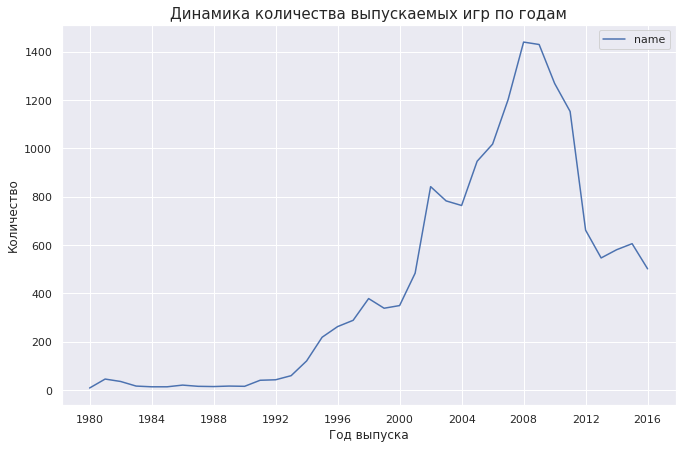

In [217]:
data = games_clean.groupby(['year_of_release']).agg({'name': 'count'})

plt.subplots(figsize = (11,7))
sns.lineplot(data=data)
plt.title('Динамика количества выпускаемых игр по годам', fontsize = 15);
plt.ylabel("Количество", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.show();


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Видим интересную картину: 
 - до начала 1990х годов индустрия ирг была в зачаточном состоянии
 - с 1990 по примерно 2008 видим быстрый рост кодичества выпускаемых игр
 - начиная с 2008 мы видим падение кодичества игр, связанное со структурными изменениями в отрасли: появляются сетевые игры, в которые играют годами: время, когда люди покупали игру убивали финального босса и идут за новой проходит
 - с 2012 года видим стабилизацию количества игр

<div>

### Динамика продаж

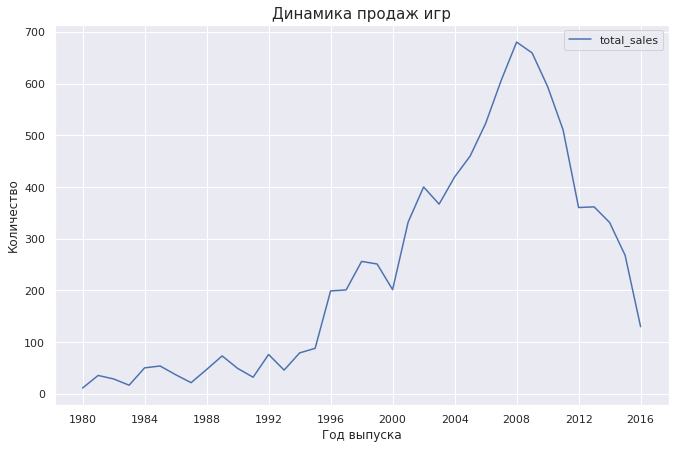

In [218]:
data = games_clean.groupby(['year_of_release']).agg({'total_sales': 'sum'})

plt.subplots(figsize = (11,7))
sns.lineplot(data=data)
plt.title('Динамика продаж игр', fontsize = 15);
plt.ylabel("Количество", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.show();

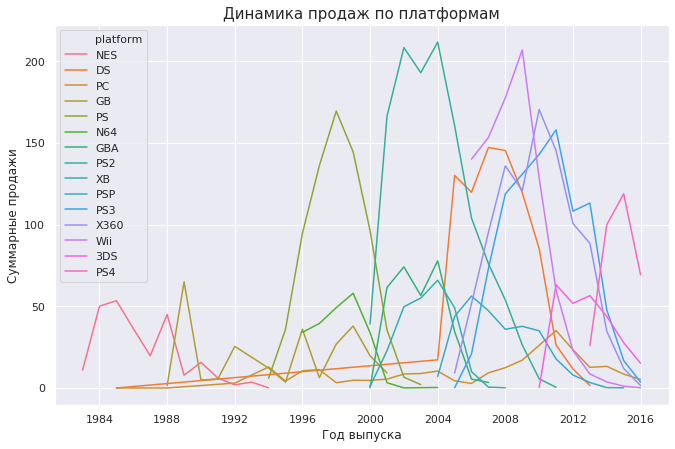

In [219]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(15).index
data = games_clean.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("platform in @top_platform"), x='year_of_release', y='total_sales', hue='platform')
plt.title('Динамика продаж по платформам', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

In [220]:
data = games_clean.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()
data.head()

,year_of_release,platform,total_sales
0,1980-01-01,2600,11.38
1,1981-01-01,2600,35.69
2,1982-01-01,2600,28.88
3,1983-01-01,2600,5.84
4,1983-01-01,NES,10.96


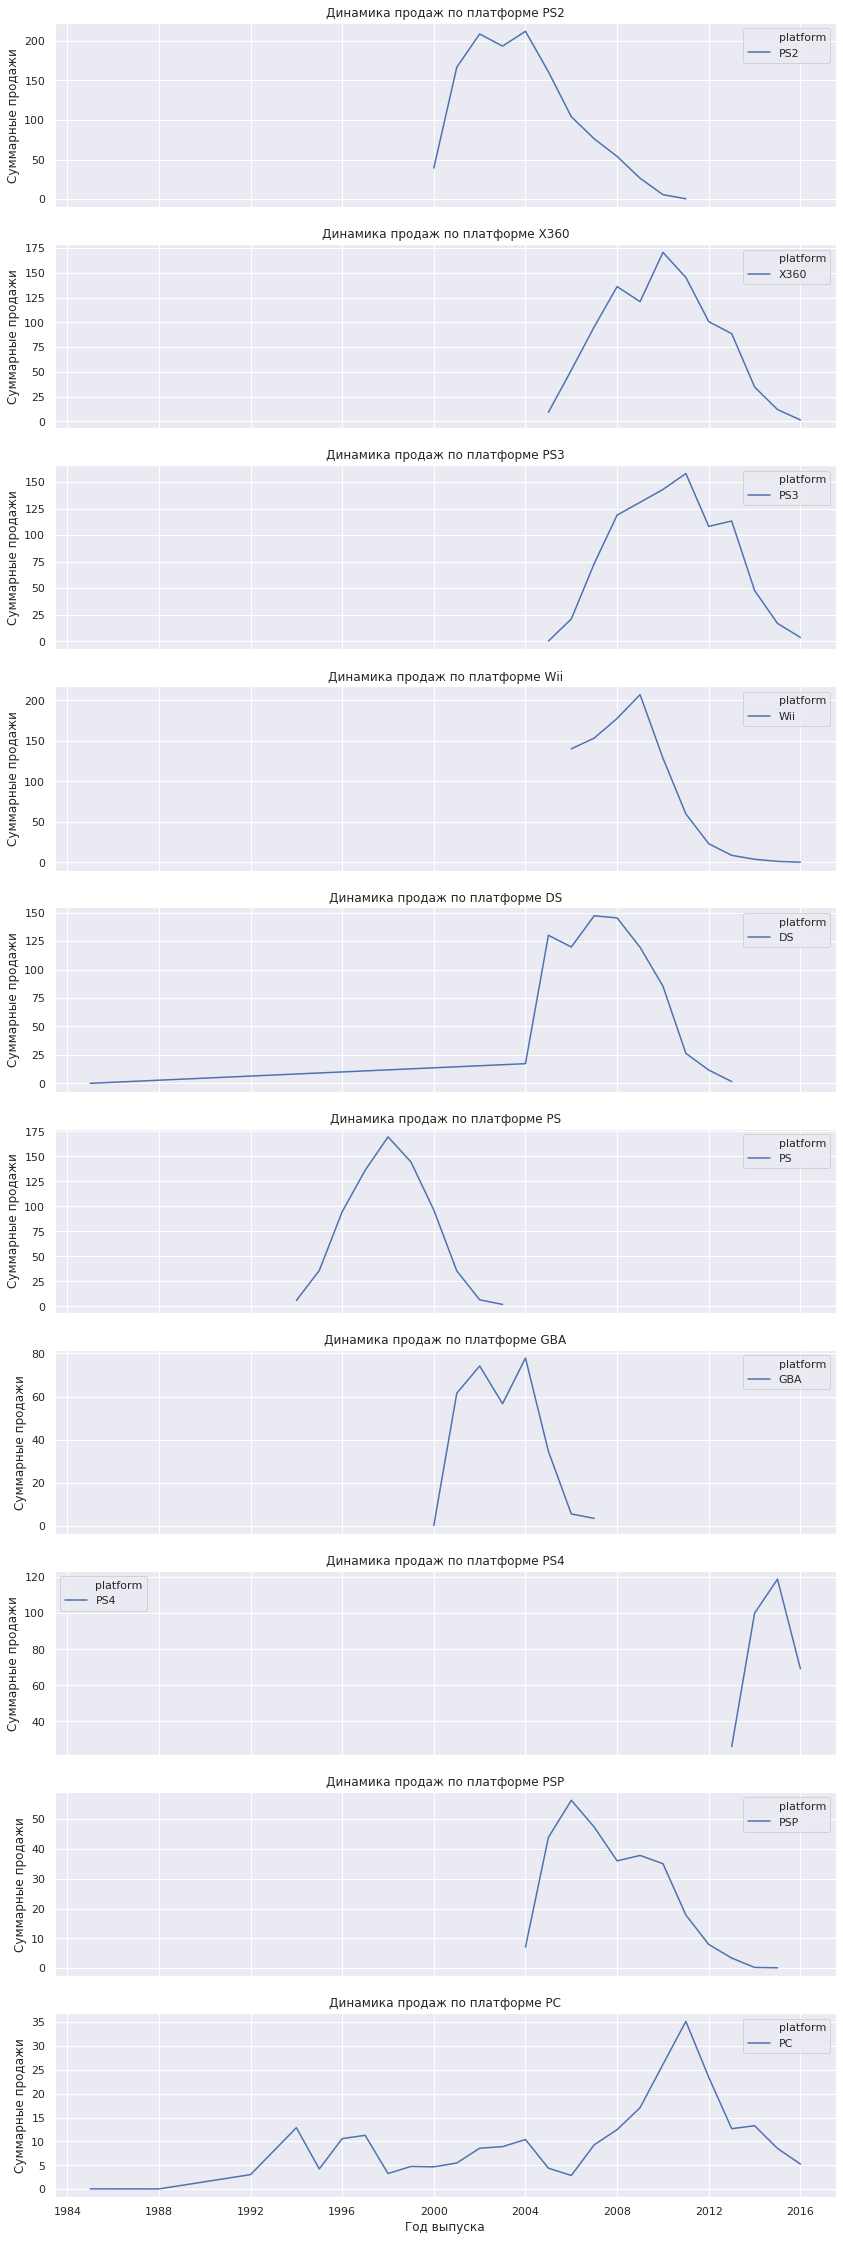

In [221]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index
data = games_clean.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()

fig, axes = plt.subplots(len(top_platform), 1, figsize=(14, 40), sharex=True)
for axnum, platform in enumerate(top_platform):
    ax = sns.lineplot(ax=axes[axnum], data=data.query("platform == @platform"), x='year_of_release', y='total_sales', hue='platform')
    ax.set(xlabel ="Год выпуска", ylabel = "Суммарные продажи", title =f'Динамика продаж по платформе {platform}')


In [222]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(20).index
games_clean \
    .query("platform in @top_platform and total_sales>1") \
    .groupby('platform') \
    .agg({'year_of_release': ['min', 'max']}).reset_index()

platform year_of_release           
                        min        max
0      2600      1980-01-01 1983-01-01
1       3DS      2011-01-01 2016-01-01
2        DS      2004-01-01 2012-01-01
3        GB      1988-01-01 2001-01-01
4       GBA      2001-01-01 2007-01-01
5        GC      2001-01-01 2006-01-01
6       N64      1996-01-01 2000-01-01
7       NES      1983-01-01 1993-01-01
8        PC      1992-01-01 2015-01-01
9        PS      1994-01-01 2003-01-01
10      PS2      2000-01-01 2009-01-01
11      PS3      2006-01-01 2015-01-01
12      PS4      2013-01-01 2016-01-01
13      PSP      2004-01-01 2010-01-01
14     SNES      1990-01-01 1996-01-01
15      Wii      2006-01-01 2014-01-01
16     WiiU      2012-01-01 2016-01-01
17     X360      2005-01-01 2015-01-01
18       XB      2001-01-01 2006-01-01
19     XOne      2013-01-01 2016-01-01

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Видим, что
 - если количество игр стабилизировалось, то продажи лицензий в штуках продолжают падать. это объясняется так изменением стукруты отрасли: однажды купив игру пользователь играет в нее несколько лет и не приобретает ее кажды рах заново
 - платформы появляются и исчезают. при этом есть зарактерный "путь жизни" платформы: он длится примерно 6-10 лет. Включает в себя симметрийчный рост и падение
    
<div>

### Выбор актуального периода для исследования

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Выберем период, начиная с 2012 года, когда структура отрасли стабилизировалась
    
<div>

In [223]:
games_actual = games_clean.query("year_of_release>=2012")

### Продажи по платформам

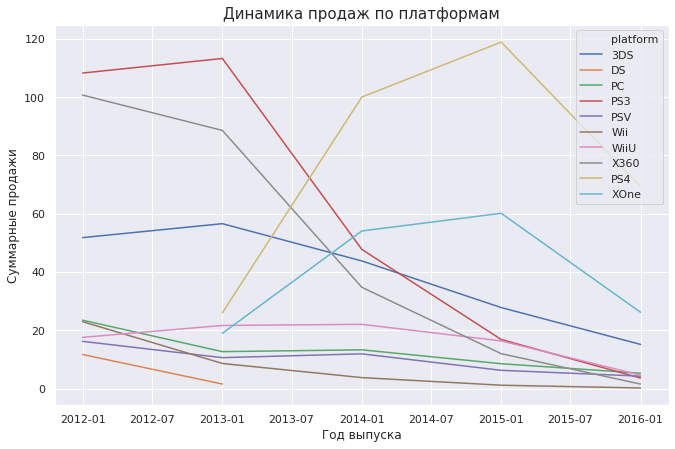

In [224]:
top_platform = games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index
data = games_actual.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("platform in @top_platform"), x='year_of_release', y='total_sales', hue='platform')
plt.title('Динамика продаж по платформам', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

<div style="border:solid gray 2.0px; padding: 10px"> 
    
На графике видно много платформ, но:
    
 - большинство платформ находятся в конце срока жизни

 - наибольший интерес представляют три платформы с точки зрения продаж
     - XOne
     - PS4
     - 3DS
     - WiiU
 
 - платформы XOne и PS4, скорее всего, находятся в фазе роста. Падение в 2016 году связано с тем, что данные не могут быть не полными
 - платформs 3DS и WiiU появились в 2011 и 2012 годах и мы не видим резкого падения продаж в 2012-2015 годах. В 2016, возможно, был рост

<div>

In [225]:
#продажи по платформам с 2012 года
games_actual.groupby(['platform']).agg({'total_sales': 'sum'}).reset_index()

,platform,total_sales
0,3DS,195.00
1,DS,13.20
2,PC,63.16
3,PS3,289.75
4,PS4,314.25
5,PSP,11.69
6,PSV,49.19
7,Wii,36.59
8,WiiU,82.19
9,X360,237.50


In [226]:
top_platform = games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
games_actual.groupby(['name', 'platform']).agg({'total_sales': 'sum'}).reset_index().query("platform in @top_platform")

,name,platform,total_sales
0,Beyblade Burst,3DS,0.03
1,Fire Emblem Fates,3DS,1.67
2,Frozen: Olaf's Quest,3DS,0.59
4,Haikyu!! Cross Team Match!,3DS,0.04
5,Tales of Xillia 2,PS3,0.84
...,...,...,...
2890,Zumba Fitness: World Party,XOne,0.24
2891,Zyuden Sentai Kyoryuger: Game de Gaburincho!!,3DS,0.05
2893,[Prototype 2],PS3,0.74
2894,[Prototype 2],X360,0.79


In [ ]:
top_platform = games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(7).index
data = games_actual.groupby(['name', 'platform']).agg({'total_sales': 'sum'}).reset_index().query("platform in @top_platform")

xlim_max = data['total_sales'].quantile(0.75) + (data['total_sales'].quantile(0.75) - data['total_sales'].quantile(0.25))*1.5

plt.subplots(figsize = (11,7))
sns.boxplot(data=data.query('total_sales<=@xlim_max'), x="total_sales", y="platform", palette='rainbow');
plt.title('Продажи по платформам', fontsize = 15);
plt.xlabel("Продажи", fontsize = 12)
plt.ylabel("Платформа", fontsize = 12);


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Видно, что у разных ирг внутри платформ сильно различаются продажи
    
<div>

### Зависимость продаж от оценки пользователей и критиков

In [ ]:
data = games_actual.query("platform == 'PS4'")

In [ ]:
data.info()

In [ ]:
sns.relplot(x='user_score', y='total_sales', data=data)
plt.xlabel('оценка пользователей', fontsize = 12);
plt.ylabel('продажи', fontsize = 12);
plt.title('Зависимость продаж от оценки пользователей', fontsize = 15);
fig = plt.gcf()
fig.set_size_inches(12, 6);

In [ ]:
sns.relplot(x='critic_score', y='total_sales', data=data)
plt.xlabel('оценка критиков', fontsize = 12);
plt.ylabel('продажи', fontsize = 12);
plt.title('Зависимость продаж от оценки критиков', fontsize = 15);
fig = plt.gcf()
fig.set_size_inches(12, 6);

In [ ]:
top_platform = games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(7).index
corr_sales_score = pd.DataFrame(columns = ['platform', 'corr_sales-user_score', 'corr_sales-critic_score'])
for platform in top_platform:
    data = games_actual.query("platform == @platform")
    corr_sales_score.loc[len(corr_sales_score)] = \
    [platform,data['total_sales'].corr(data['user_score']),data['total_sales'].corr(data['critic_score'])]

In [ ]:
corr_sales_score

<div style="border:solid gray 2.0px; padding: 10px"> 
    
На примере платформы PS4 мы видим, что продажи зависят от оценки критиков.
Зависимость продаж от оценки пользователей не наблюдается.
    
Но, такая картина верна не для всех платформ: например, для платформ WiiU и 3DS (особенно WiiU) мы видим прямую корреляцию продаж от оценки пользователей
    
<div>

### Продажи по жанрам

In [228]:
#продажи по жанрам с 2012 года
games_actual.groupby(['genre']).agg({'total_sales': 'sum'}).reset_index().sort_values(by='total_sales', ascending=False)

,genre,total_sales
0,Action,446.00
8,Shooter,304.75
7,Role-Playing,192.75
10,Sports,181.00
3,Misc,85.31
4,Platform,61.00
6,Racing,53.50
2,Fighting,44.50
9,Simulation,35.12
1,Adventure,29.42


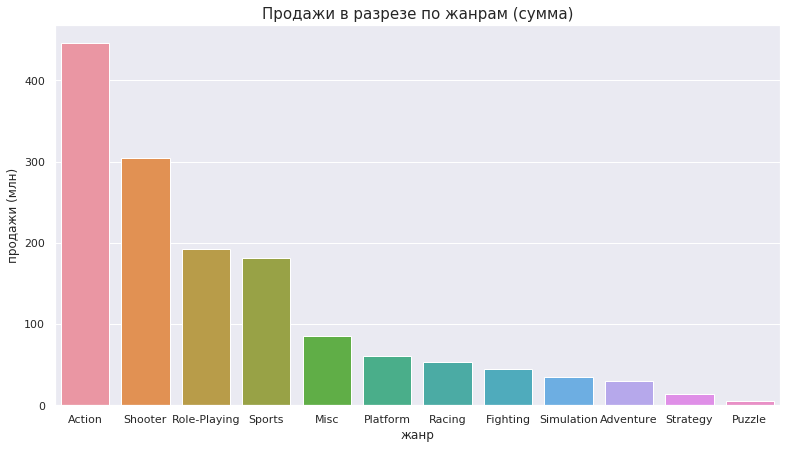

In [229]:
data = games_actual.groupby(['genre']).agg({'total_sales': 'sum'}).reset_index().sort_values(by='total_sales', ascending=False)
plt.subplots(figsize = (13,7))
sns.barplot(data = data, x='genre', y='total_sales')
plt.xlabel('жанр', fontsize = 12);
plt.ylabel('продажи (млн)', fontsize = 12);
plt.title('Продажи в разрезе по жанрам (сумма)', fontsize = 15);

<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - у нас золото: у жанра Action
 - серебро получает Shooter
 - и два претендента на бронзу: Role-Playing и Sports.
 - остальные жанры сильно отстают
   
<div>

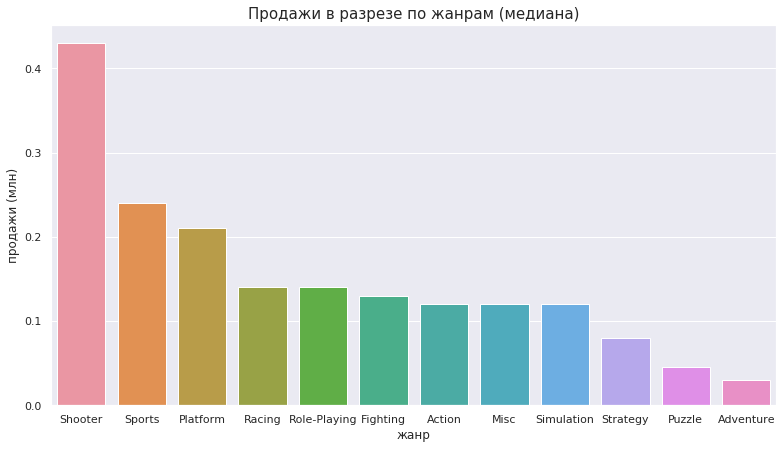

In [230]:
data = games_actual.groupby(['genre']).agg({'total_sales': 'median'}).reset_index().sort_values(by='total_sales', ascending=False)
plt.subplots(figsize = (13,7))
sns.barplot(data = data, x='genre', y='total_sales')
plt.xlabel('жанр', fontsize = 12);
plt.ylabel('продажи (млн)', fontsize = 12);
plt.title('Продажи в разрезе по жанрам (медиана)', fontsize = 15);

<div style="border:solid blue 2.0px; padding: 10px"> 
    
Сделал медиану )

Если судить по медианному значению продаж ирг, то в среднем одна игра жанра Shooter продается намного большим числом копий, чем другие жанры

<div>

## Портрет пользователей по регионам

In [231]:
games_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 16 to 16712
Data columns (total 12 columns):
name               2898 non-null object
platform           2898 non-null object
year_of_release    2898 non-null datetime64[ns]
genre              2898 non-null object
na_sales           2898 non-null float16
eu_sales           2898 non-null float16
jp_sales           2898 non-null float16
other_sales        2898 non-null float16
critic_score       1321 non-null float16
user_score         1539 non-null float16
rating             1769 non-null object
total_sales        2898 non-null float16
dtypes: datetime64[ns](1), float16(7), object(4)
memory usage: 175.5+ KB


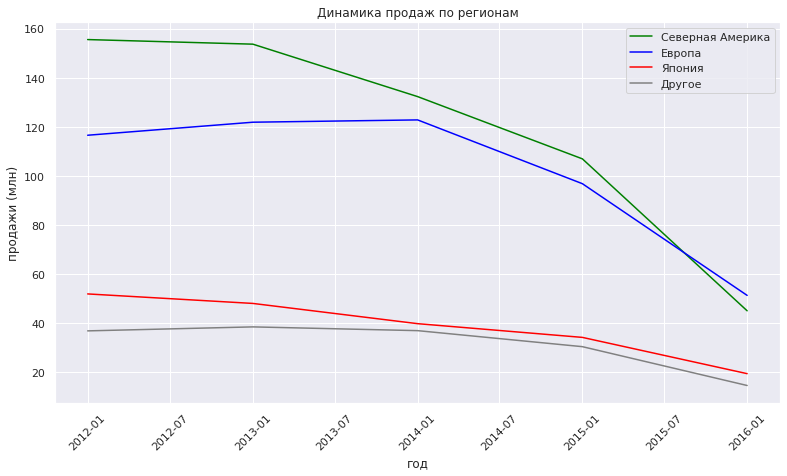

In [232]:
data = games_actual \
    .groupby('year_of_release')[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()


fig, ax = plt.subplots(figsize=(13,7))
a=sns.lineplot(data = data, x='year_of_release', y='na_sales', label='Северная Америка', color='green')
b=sns.lineplot(data = data, x='year_of_release', y='eu_sales', label='Европа', color='blue')
c=sns.lineplot(data = data, x='year_of_release', y='jp_sales', label='Япония', color='red')
d=sns.lineplot(data = data, x='year_of_release', y='other_sales', label='Другое', color='gray')

ax.set_title('Динамика продаж по регионам')
ax.set_xlabel('год')
ax.set_ylabel('продажи (млн)')
plt.xticks(rotation=45);

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Продажи в Северной Америке и Европе выше, но и падают они быстрее. В Северной Америке оно выражено в наибольшей степени

<div>

In [233]:
def portrait (df, col):
    data = games_actual \
        .pivot_table(values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], index=col, aggfunc='sum') \
        .reset_index() \
        .sort_values(by='total_sales', ascending=False)

    for col in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']:
        data[col] = data[col] / data[col].sum() *100
        
    return data

### Портрет по платформам

In [234]:
portrait(df = games_actual, col = 'platform')

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
4,PS4,27.73,8.27,18.33,30.83,21.64
3,PS3,21.06,18.30,17.50,27.69,19.95
9,X360,14.71,0.81,23.69,13.07,16.36
0,3DS,8.41,45.53,9.36,5.68,13.43
10,XOne,10.14,0.18,15.70,9.11,10.97
8,WiiU,4.93,6.75,6.42,3.80,5.66
2,PC,7.49,0.00,3.24,3.72,4.35
6,PSV,2.23,10.91,1.85,3.70,3.39
7,Wii,2.42,1.76,3.06,1.74,2.52
1,DS,0.74,1.93,0.83,0.50,0.91


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - бросается в глаза Япония, в которой почти половина (45%) продаж приходится на платформу 3DS, так же полулярны платформы PS3, PSV, PS4
    
 - в Европе платформы PS3 и PS4 (PlayStation) забирают половину продаж. X360 и XOne имеют долю 15% и 10% соответственно
    
 - в Северной Америке нет ярко выраженного лидера. PlayStation (PS4+PS3) имеет около 35%. X360 около 24%, XOne около 15%.
    
 - в остальных регионах выделяется PlayStation (около 60%) и X360 (13%)
    
<div>

### Портрет по жанрам

In [235]:
portrait(df = games_actual, col = 'genre')

,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales
0,Action,31.73,27.39,30.38,32.97,30.72
8,Shooter,22.30,4.79,24.41,23.77,20.98
7,Role-Playing,9.53,33.94,10.79,9.46,13.27
10,Sports,13.58,4.15,13.74,14.32,12.46
3,Misc,5.17,6.79,6.44,4.89,5.88
4,Platform,4.21,4.48,4.28,3.56,4.20
6,Racing,5.36,1.30,2.90,4.14,3.68
2,Fighting,2.12,4.89,3.34,2.85,3.07
9,Simulation,2.86,5.40,1.34,1.40,2.42
1,Adventure,1.86,4.27,1.50,1.79,2.03


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - жанр Action популярен везде
    
 - жанр Role-Playing очень популярен в Японии (34%) и имеет долю около 10% по остальным регионам
    
 - в игры жанра Shooter играют в большей степени в Европе, Северной Америке и регионе other (около 20-25%). В Японии этот жанр не так популярен
    
 - в спортивные игры (Sports) играют в большей степени в Европе, Северной Америке и регионе other (около 14%). В Японии этот жанр не так популярен    
    
<div>

### Влияние ESRB 

In [236]:
portrait(df = games_actual, col = 'rating')

,rating,eu_sales,jp_sales,na_sales,other_sales,total_sales
2,M,47.25,25.25,47.59,49.62,46.03
0,E,26.44,32.69,23.14,23.69,25.17
3,T,12.61,32.47,13.49,13.80,14.65
1,E10+,13.71,9.58,15.73,12.85,14.17


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - видна схожая картина для регионов в Европа, Северная Америке и Другое:
    - около 50% на "M - Для взрослых"
    - около 25% на "E - Для всех"
    - около 13% на "T - Для подростков"    
    - около 12-15% на "E10+ - Для всех от 10 лет"        
    
 - В Японии другая картина:
    - около 25% на "M - Для взрослых"
    - около 33% на "E - Для всех"
    - около 32% на "T - Для подростков"    
    - около 10% на "E10+ - Для всех от 10 лет"        
    
<div>

## Проверка гипотез

### Формулировка гипотез

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Сформируем нулевую и альтернативную гипотезы:

**1. Пользовательские рейтинги платформ Xbox One и PC**
 - **Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
 - **Альтернативная гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC различаются

<span style="color: white">. </span>

**2. Средние пользовательские рейтинги жанров Action и Sports:**
 - **Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action и Sports одинаковые
 - **Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action и Sports разные

<div>

### Проверка гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC 

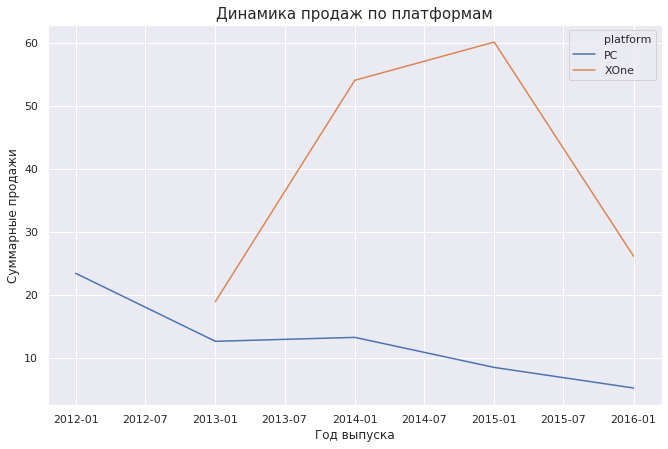

In [237]:
data = games_actual.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("platform in ['PC', 'XOne']"), x='year_of_release', y='total_sales', hue='platform')
plt.title('Динамика продаж по платформам', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Для проверки гипотезы будем брать период, в котором обе платформы существовали. Это 2013-2016 года
    
<div>

In [238]:
games_hyp_PC   = games_actual.query("year_of_release>=2013 and year_of_release<=2016 and platform=='PC' and user_score.notna()")
games_hyp_XOne = games_actual.query("year_of_release>=2013 and year_of_release<=2016 and platform=='XOne' and user_score.notna()")

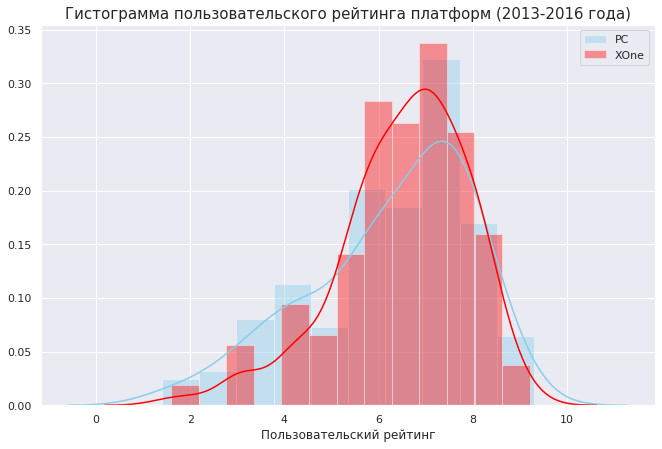

In [239]:
plt.subplots(figsize = (11,7))
sns.distplot(games_hyp_PC['user_score'], color="skyblue", label="PC", kde=True)
sns.distplot(games_hyp_XOne['user_score'], color="red"    , label="XOne", kde=True)
plt.title('Гистограмма пользовательского рейтинга платформ (2013-2016 года)', fontsize = 15);
plt.xlabel("Пользовательский рейтинг", fontsize = 12)
plt.legend();

In [240]:
print("Средний пользовательский рейтинг платформы PC: " + str(games_hyp_PC['user_score'].mean()))
print("Средний пользовательский рейтинг платформы XOne: " + str(games_hyp_XOne['user_score'].mean()))

Средний пользовательский рейтинг платформы PC: 6.266
Средний пользовательский рейтинг платформы XOne: 6.523


In [241]:
alpha = 0.01

results = st.ttest_ind(
    games_hyp_PC['user_score'], 
    games_hyp_XOne['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.12844639799306318
Не получилось отвергнуть нулевую гипотезу


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Не можем отвергнуть нулевую гипотезу, т.е. мы не можем утверждать с заданной степенью уверенности, что средние пользовательских рейтингов платформ Xbox One и PC отличаются

<div>

### Проверка гипотезы о равенстве средних пользовательских рейтингов жанров Action и Sports

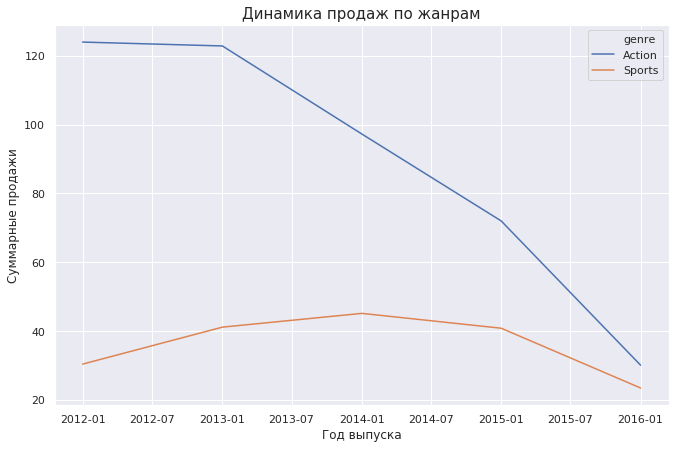

In [242]:
data = games_actual.groupby(['year_of_release', 'genre']).agg({'total_sales': 'sum'}).reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("genre in ['Action', 'Sports']"), x='year_of_release', y='total_sales', hue='genre')
plt.title('Динамика продаж по жанрам', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Оставляем весь период
    
<div>

In [243]:
games_hyp_Action = games_actual.query("year_of_release>=2012 and year_of_release<=2016 and genre=='Action' and user_score.notna()")
games_hyp_Sports = games_actual.query("year_of_release>=2012 and year_of_release<=2016 and genre=='Sports' and user_score.notna()")

In [244]:
print("Средний пользовательский рейтинг жанра Action: " + str(games_hyp_Action['user_score'].mean()))
print("Средний пользовательский рейтинг жанра Sports: " + str(games_hyp_Sports['user_score'].mean()))

Средний пользовательский рейтинг жанра Action: 6.832
Средний пользовательский рейтинг жанра Sports: 5.457


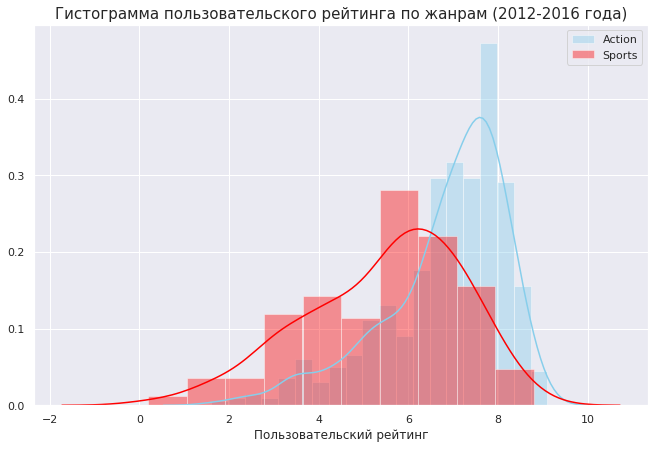

In [245]:
plt.subplots(figsize = (11,7))
sns.distplot(games_hyp_Action['user_score'], color="skyblue", label="Action", kde=True)
sns.distplot(games_hyp_Sports['user_score'], color="red"    , label="Sports", kde=True)
plt.title('Гистограмма пользовательского рейтинга по жанрам (2012-2016 года)', fontsize = 15);
plt.xlabel("Пользовательский рейтинг", fontsize = 12)
plt.legend();

In [246]:
alpha = 0.01

results = st.ttest_ind(
    games_hyp_Action['user_score'], 
    games_hyp_Sports['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.496451417513366e-26
Отвергаем нулевую гипотезу


<div style="border:solid gray 2.0px; padding: 10px"> 
    
Отвергаем нулевую гипотезу, т.е. мы убедились, что пользовательские рейтинги жанров не равны

По среднему значению делаем вывод, что средний пользовательский рейтинги жанра Action значимо выше среднего пользовательского рейтинга жанра Sports

<div>

## Прогноз продаж

<div style="border:solid gray 2.0px; padding: 10px"> 
    
На основании выбранного нами периода все данные мы можем разделить на три группы:

 - продажи ирг по платформам, находящимся в фазе роста (XOne и PS4)
 - продажи ирг по платформам, находящимся в фазе падения (3DS, PS3, X360)
 - продажи ирг по платформам, находящимся в фазе стагнации (WiiU)    
 - остальными платформами пренебрежем
    
<div>

**топ 6 платформ с 2012 года**

In [247]:
games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6).index

Index(['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU'], dtype='object', name='platform')

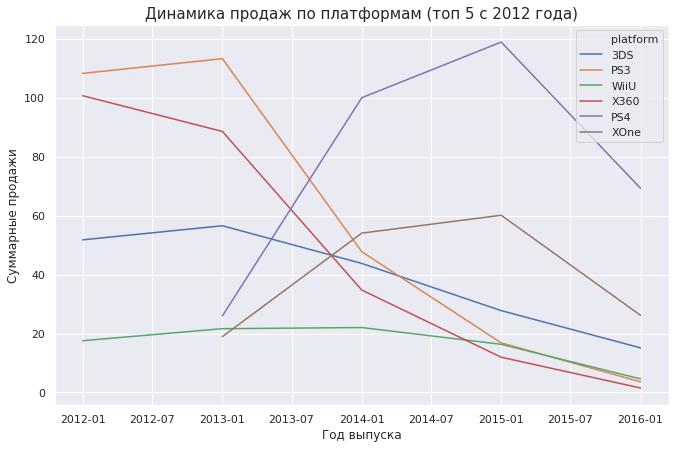

In [248]:
top_platform = games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6).index
data = games_actual.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}).reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("platform in @top_platform"), x='year_of_release', y='total_sales', hue='platform')
plt.title('Динамика продаж по платформам (топ 5 с 2012 года)', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

**жизненный цикл топовых платформ за все время**

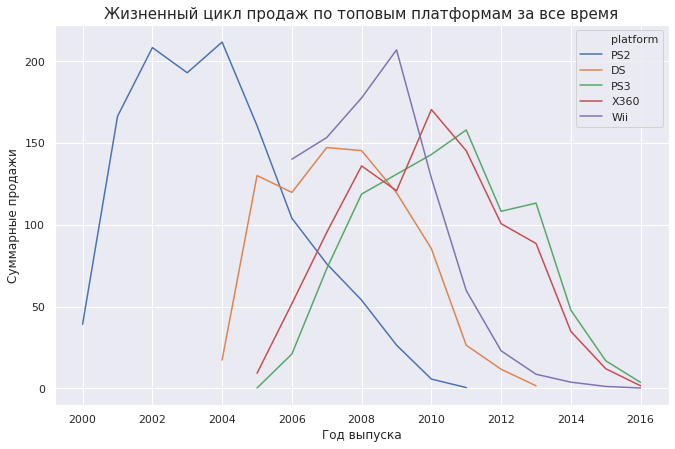

In [249]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index

data = games_clean \
    .query("year_of_release>=2000") \
    .groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}) \
    .reset_index()

plt.subplots(figsize = (11,7))
sns.lineplot(data=data.query("platform in @top_platform"), x='year_of_release', y='total_sales', hue='platform')
plt.title('Жизненный цикл продаж по топовым платформам за все время', fontsize = 15);
plt.ylabel("Суммарные продажи", fontsize = 12)
plt.xlabel("Год выпуска", fontsize = 12)
plt.legend()
plt.show();

### продажи ирг по платформам, находящимся в фазе роста (XOne и PS4)

In [250]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(20).index
games_clean \
    .query("platform in ['XOne', 'PS4'] and total_sales>1") \
    .groupby('platform') \
    .agg({'year_of_release': ['min', 'max']}).reset_index()

platform year_of_release           
                       min        max
0      PS4      2013-01-01 2016-01-01
1     XOne      2013-01-01 2016-01-01

In [251]:
games_actual \
    .query("platform in ['XOne', 'PS4']") \
    .groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}) \
    .reset_index() \
    .sort_values(by=['platform', 'year_of_release'])

,year_of_release,platform,total_sales
0,2013-01-01,PS4,25.98
2,2014-01-01,PS4,100.00
4,2015-01-01,PS4,118.88
6,2016-01-01,PS4,69.25
1,2013-01-01,XOne,18.95
3,2014-01-01,XOne,54.06
5,2015-01-01,XOne,60.12
7,2016-01-01,XOne,26.16


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - Мы видим, что пик продаж в жизненном цикле приходятся обычно на 3-5 года существования платформ
 - Обе платформы (XOne и PS4) появились в 2013 годах. 2015-й год был третьим в жизненном цикле. данные по 2016-му, скорее всего, не полные. Можно предположить, что 2017й будет поход на 2015-й.
 - Наш прогноз по этим двум платформам: он будет примерно равен продажам 2015-го
    
    
<div>

### продажи ирг по платформам, находящимся в фазе падения (3DS,  PS3, X360)

In [252]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(20).index
games_clean \
    .query("platform in ['3DS', 'PS3', 'X360'] and total_sales>1") \
    .groupby('platform') \
    .agg({'year_of_release': ['min', 'max']}).reset_index()

platform year_of_release           
                       min        max
0      3DS      2011-01-01 2016-01-01
1      PS3      2006-01-01 2015-01-01
2     X360      2005-01-01 2015-01-01

In [253]:
games_actual \
    .query("platform in ['3DS', 'PS3', 'X360']") \
    .groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}) \
    .reset_index() \
    .sort_values(by=['platform', 'year_of_release'])

,year_of_release,platform,total_sales
0,2012-01-01,3DS,51.78
3,2013-01-01,3DS,56.56
6,2014-01-01,3DS,43.78
9,2015-01-01,3DS,27.78
12,2016-01-01,3DS,15.13
1,2012-01-01,PS3,108.25
4,2013-01-01,PS3,113.25
7,2014-01-01,PS3,47.75
10,2015-01-01,PS3,16.83
13,2016-01-01,PS3,3.60


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - Мы видим, что эти платформы сейчас теряют около половины продаж ежегодно. 2016 исключаем как не полный.
 - Наш прогноз по этим трем платформам: продажи будут примерно в 4 раза ниже уровня 2015 года
    
<div>

### продажи ирг по платформам, находящимся в фазе стагнации (WiiU)

In [254]:
top_platform = games_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(20).index
games_clean \
    .query("platform in ['WiiU'] and total_sales>1") \
    .groupby('platform') \
    .agg({'year_of_release': ['min', 'max']}).reset_index()

platform year_of_release           
                       min        max
0     WiiU      2012-01-01 2016-01-01

In [255]:
games_actual \
    .query("platform in ['WiiU']") \
    .groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'}) \
    .reset_index() \
    .sort_values(by=['platform', 'year_of_release'])

,year_of_release,platform,total_sales
0,2012-01-01,WiiU,17.56
1,2013-01-01,WiiU,21.64
2,2014-01-01,WiiU,22.03
3,2015-01-01,WiiU,16.34
4,2016-01-01,WiiU,4.60


<div style="border:solid gray 2.0px; padding: 10px"> 
    
 - Эта платформа выглядит стабильной или начинающей падение
 - Наш прогноз по этой платформе: продажи будут примерно в 2 раза ниже уровня 2015 года
    
<div>

### итоговый прогноз на 2017 год

<div style="border:solid gray 2.0px; padding: 10px"> 
    
Сложим все, что спрогнозировали

<div>

In [256]:
predict_XOne = games_actual.query("platform =='XOne' and year_of_release==2015")['total_sales'].sum()
predict_PS4 = games_actual.query("platform =='PS4' and year_of_release==2015")['total_sales'].sum()

predict_3DS = games_actual.query("platform =='3DS' and year_of_release==2015")['total_sales'].sum() / 4
predict_PS3 = games_actual.query("platform =='PS3' and year_of_release==2015")['total_sales'].sum() / 4
predict_X360 = games_actual.query("platform =='X360' and year_of_release==2015")['total_sales'].sum() / 4

predict_WiiU = games_actual.query("platform =='WiiU' and year_of_release==2015")['total_sales'].sum() / 2

predict_total_sales_2017 = predict_XOne + predict_PS4 + predict_3DS + predict_PS3 + predict_X360 + predict_WiiU
predict_total_sales_2017

201.314453125

## Общий вывод

<div style="border:solid gray 2.0px; padding: 10px"> 

1.  Портреты пользователей
 - Портреты пользователей игр в разных регионах различаются: можно условно поделить на Японию и все остальное.
 - В Японии создается множество ирг для подростков и лидирующей платформой в период 2012-2016 года является 3DS. 
 - В других регионах преобладает платформа PS, а так же игры для взрослых или для всех



2. Мы проверили гипотезы и выяснили, что: 
 - средние пользовательских рейтингов платформ Xbox One и PC равны
 - средний пользовательский рейтинги жанра Action значимо выше среднего пользовательского рейтинга жанра Sports



3. Сделали прогноз общих продпж на 207 год: 201 миллион копий


<div>